# Solution: Modelling additional vaccine effects

### Differential equations for a vaccine model with combined leaky effect:

\begin{align}
\frac{dS}{dt} & = -(\beta \frac{I}{N}+ c_{i} \beta \frac{I_{V}}{N}) S \\
\\
\frac{dI}{dt} & = (\beta \frac{I}{N}+ c_{i} \beta \frac{I_{V}}{N}) S - \gamma I  \\
\\
\frac{dI_{V}}{dt} & = c_{s} (\beta \frac{I}{N} + c_{i} \beta \frac{I_{V}}{N}) V - \gamma I_{V} \\
\\
\frac{dR}{dt} & = \gamma I + \gamma I_{V} \\
\\
\frac{dV}{dt} & = - c_{s}(\beta \frac{I}{N} + c_{i} \beta \frac{I_{V}}{N}) V 
\end{align}

### Based on the code, what is the efficacy of the vaccine in terms of reducing susceptibility and in terms of reducing infectivity?

Since c_s = 0.3 and c_i = 0.5 in the code, the vaccine efficacy in terms of reducing susceptibility is $(1-c_s) \times 100$ = 70% and the vaccine efficacy in terms of reducing infectivity is $(1-c_i) \times 100$ = 50%. This means that those who are infected after being vaccinated are half as infectious as those who never received the vaccine. 

**Modelling the impact of the combined leaky vaccine with 60% coverage**:

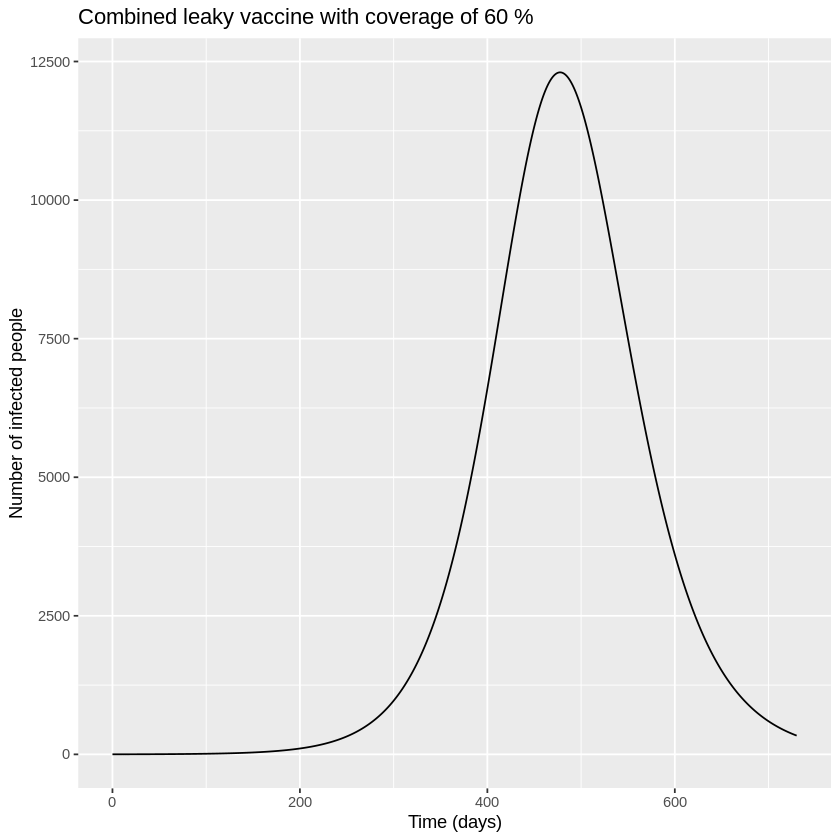

In [1]:
# LOAD THE PACKAGES:
library(deSolve)
library(reshape2)
library(ggplot2)

# MODEL INPUTS:

# Specify the total population size
N <- 1000000

# Specify the vaccination coverage
p <- 0.6                                    # 60% coverage

# Initial number of people in each compartment
initial_state_values <- c(S = (1-p)*N,  # the unvaccinated proportion of the
                                        # population is susceptible
                          I = 1,        # the epidemic starts with a single
                                        # infected person
                          R = 0,        # there is no prior immunity in
                                        # the population
                          V = p*N,      # a proportion p of the population is
                                        # vaccinated (vaccination coverage) 
                          Iv = 0)       # no vaccinated individual has been
                                        # infected at the beginning of the
                                        # simulation

# Parameters
parameters <- c(beta = 0.25,     # the infection rate in units of days^-1
                gamma = 0.1,     # the rate of recovery in units of days^-1
                c_s = 0.3,       # the reduction in the force of infection
                                 # acting on those vaccinated
                c_i = 0.5)       # the reduction in the infectivity of
                                 # vaccinated infected people       

# TIMESTEPS:

# Sequence of timesteps to solve the model at
times <- seq(from = 0, to = 730, by = 1)   # from 0 to 2 years, daily intervals

# MODEL FUNCTION: 

vaccine_model <- function(time, state, parameters) {  

    with(as.list(c(state, parameters)), {    
        
    # Defining lambda as a function of beta and I:
      lambda <- beta * I/N + c_i * beta * Iv/N 
     # the Iv compartment is c_i times less infectious than the I compartment
        
    # The differential equations
      dS <- -lambda * S            
      dI <- lambda * S - gamma * I   
      dR <- gamma * I + gamma * Iv            # infected and vaccinated infected
                                              # individuals recover at the same rate   
      dV <- -c_s * lambda * V                 # vaccinated people become infected at
                                              # a rate c_s * lambda
      dIv <- c_s * lambda * V - gamma * Iv    # vaccinated people who become infected
                                              # move into the Iv compartment
      
    # Return the number of people in each compartment at each timestep 
    # (in the same order as the input state variables)
    return(list(c(dS, dI, dR, dV, dIv))) 
    })
  
}

# MODEL OUTPUT:

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = vaccine_model,
                            parms = parameters))

# PLOT THE OUTPUT

# Plot the number of infected people over time
ggplot(data = output,                                               
       aes(x = time, y = I+Iv)) +   # infected people are in the I and Iv compartment
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Number of infected people") +
  labs(title = paste("Combined leaky vaccine with coverage of", p*100, "%"))

###  What is the peak prevalence (number of infected people) with a vaccine coverage of 60%?

The plot shows that nearly 12500 people are infected at the peak of the epidemic - this includes both vaccinated and unvaccinated people (the I and I<sub>V</sub> compartment).

###  For this vaccine, what is the minimum vaccination coverage required to interrupt transmission, i.e. to bring R<sub>eff</sub> below 1? Calculate this on paper, then confirm the value you derived using your model. 

We can calculate this in a similar way to the previous etivity, first relating R<sub>eff</sub> to R<sub>0</sub>:

\begin{align}
R_{eff} & = (1-p) \times R_0 + p c_s c_i \times R_0
\end{align}

Then, solving this equation for p<sub>C</sub> = *p* when R<sub>eff</sub> = 1:

\begin{align}
p_c & = \frac{1-\frac{1}{R_0}}{1- c_s \times c_i} \\
p_c & = \frac{1-\frac{1}{\frac{0.25}{0.1}}}{1- 0.3 \times 0.5} \\
p_c & = 0.71
\end{align}

That is, we need to vaccinate at least 71% of the population in order to interrupt transmission (R<sub>eff</sub> < 1).

**Modelling the minimum vaccine coverage required to interrupt transmission:**

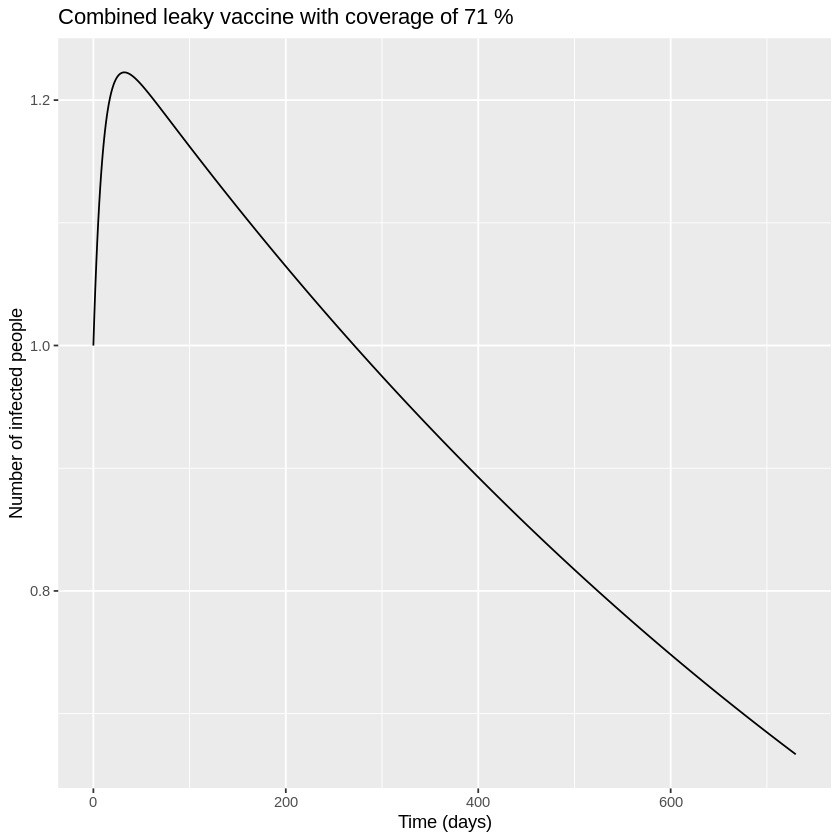

In [2]:
# Specify the vaccination coverage
p <- 0.71                                  # 71% coverage 

# Also need to update this in the initial conditions:
# Initial number of people in each compartment
initial_state_values <- c(S = (1-p)*N,    # the unvaccinated proportion of the
                                          # population is susceptible
                          I = 1,          # the epidemic starts with a
                                          # single infected person
                          R = 0,          # there is no prior immunity in 
                                          # the population
                          V = p*N,        # a proportion p of the population
                                          # is vaccinated (vaccination coverage) 
                          Iv = 0)         # no vaccinated individual has been
                                          # infected at the beginning of the
                                          # simulation


# MODEL OUTPUT:

# Solving the differential equations using the ode integration algorithm
output <- as.data.frame(ode(y = initial_state_values, 
                            times = times, 
                            func = vaccine_model,
                            parms = parameters))

# Plot the number of infected people over time
ggplot(data = output,                                               
       aes(x = time, y = I+Iv)) +    # infected people are in the I and Iv compartment
  geom_line() +                                                          
  xlab("Time (days)")+                                                   
  ylab("Number of infected people") +
  labs(title = paste("Combined leaky vaccine with coverage of", p*100, "%")) + 
  

The plot above shows that, with a coverage of 71%, the number of infected people immediately goes into decline (from the 1 infected case at the beginning of the simulation). The lack of epidemic can also be visualised by adding a limit to the y axis to show the whole population size in the ggplot code: ```+ylim(c(0,N))```.